*Matt Braaksma*

*March 5, 2023*

*APEC 8601*

*Prof. Justin Johnson*


---



# Problem set 2: Hands on with sustainability models

This problem set will have you work through several sustainability models. To turn this in, please submit a PDF of your completed notebook and upload to the assignment on canvas. There are lots of ways to convert a completed Jupyter Notebook to PDF, including the Export feature in VS Code in the "..." options menu above this notebook. The most robust way is to use Quarto (https://quarto.org/docs/getting-started.html), which I had you install as a VS Code Extension. The easiest way to do that is open up a Command Prompt/Terminal in the folder where your notebook is and type `quarto render problem_set_2.ipynb --to pdf`. This will create a PDF in the same folder as your notebook.



## Required imports

In [2]:
import os, sys
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dicelib  # https://github.com/mptouzel/PyDICE

import ipywidgets as widgets  # interactive display

plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)

%matplotlib inline
sns.set_style("ticks", {"axes.grid": False})
params = {"lines.linewidth": "3"}
plt.rcParams.update(params)
display(HTML("<style>.container { width:100% !important; }</style>"))

## Helper Functions

In [3]:
def plot_future_returns(gamma, random_seed):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    np.random.seed(random_seed)
    undiscounted_utility_time_series = np.random.rand(time_steps)
    ax[0].plot(undiscounted_utility_time_series)

    discounted_utility_time_series = undiscounted_utility_time_series * np.power(
        gamma, np.arange(time_steps)
    )
    ax[0].plot(discounted_utility_time_series)

    cumulsum_discounted_utility_time_series = np.cumsum(discounted_utility_time_series)
    ax[1].plot(
        cumulsum_discounted_utility_time_series * (1 - gamma),
        color="C1",
        label=r"discounted on $1/(1-\gamma)=$"
        + "\n"
        + r"$"
        + str(round(1 / (1 - gamma)))
        + "$-step horizon",
    )
    cumulsum_undiscounted_utility_time_series = np.cumsum(
        undiscounted_utility_time_series
    )
    ax[1].plot(
        cumulsum_undiscounted_utility_time_series
        / cumulsum_undiscounted_utility_time_series[-1],
        label="undiscounted",
        color="C0",
    )
    ax[1].axvline(1 / (1 - gamma), ls="--", color="k")

    ax[0].set_ylabel("utility at step t")
    ax[0].set_xlim(0, time_steps)
    ax[0].set_xlabel("time steps into the future")
    ax[1].legend(frameon=False)
    ax[1].set_ylabel("future return (normalized)")
    ax[1].set_xlabel("time steps into the future")
    ax[1].set_xlim(0, time_steps)
    fig.tight_layout()

## Question 1

Write a for loop that tests the DICE model to see how the total damages in 2100 change when there is a value of 2 versus 3 for the damage function coefficient. Output a figure for each of the two values and then report out the actual value of total damage.


Running DICE, a3=2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4517.318954614702
            Iterations: 95
            Function evaluations: 19230
            Gradient evaluations: 95
Running DICE, a3=3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4416.94398539428
            Iterations: 88
            Function evaluations: 17821
            Gradient evaluations: 88


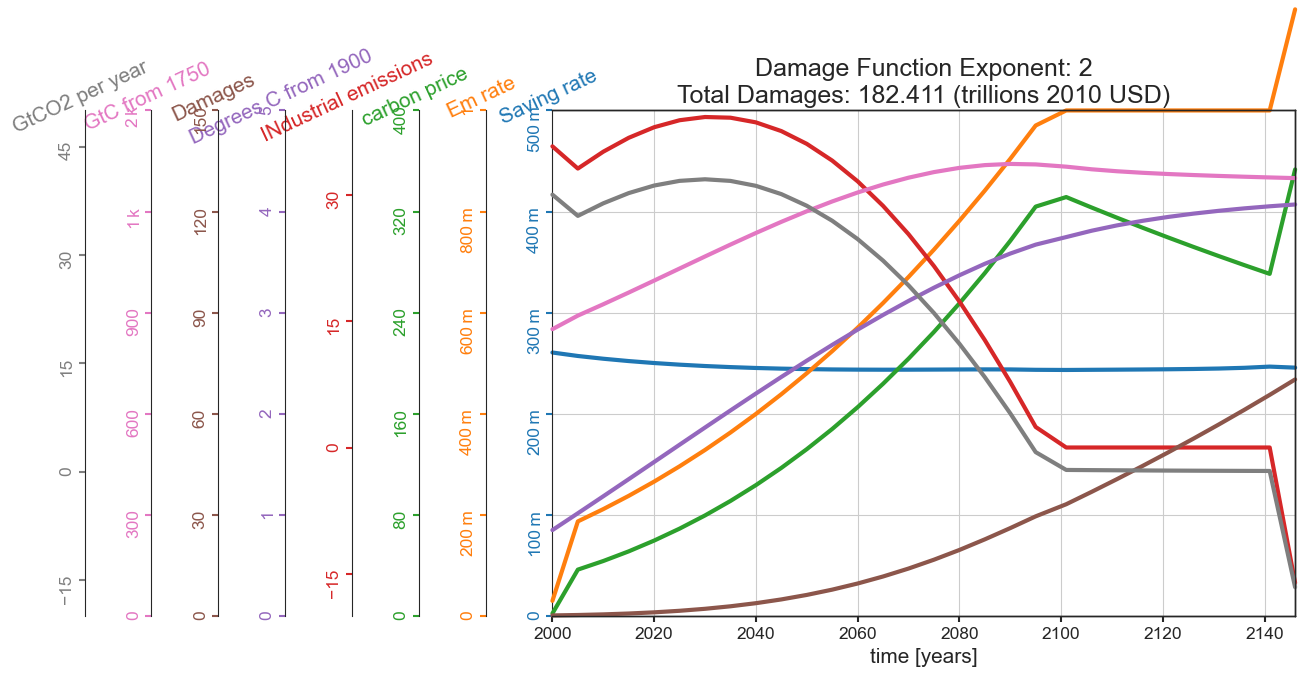

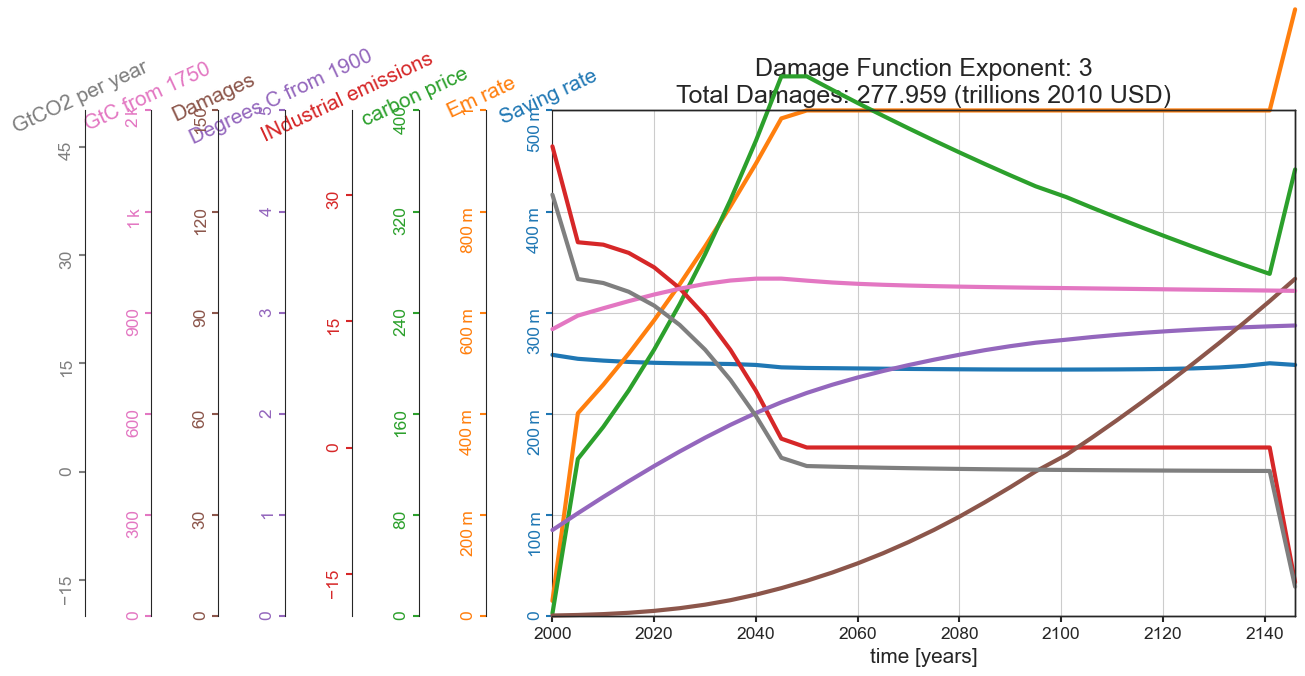

In [113]:
# Loop through damage coefficients
for damage_exp in [2,3]:
    print('Running DICE, a3=' + str(damage_exp))
    dice_model = dicelib.DICE()  # create an instance of the model
    dice_model.init_parameters(a3=damage_exp) # set damage coefficient
    dice_model.init_variables()
    controls_start_std, controls_bounds_std = dice_model.get_control_bounds_and_startvalue()
    dice_model.optimize_controls(controls_start_std, controls_bounds_std)
    dice_model.roll_out(dice_model.optimal_controls)
    total_damages = sum(dice_model.DAMAGES[0:20]) # save total damages through 2100
    dice_model.plot_run('Damage Function Exponent: ' + str(damage_exp) + '\nTotal Damages: {:.3f} (trillions 2010 USD)'.format(total_damages))


## Question 2

Run the MAGICC model for the 4 main RCPs (2.6, 4.5, 7.0, 8.5). Plot the temperature of each pathway on (a single or seperate) graphs. Report out what is the expected temperature in 2100 for each RCP.

In [108]:
# Import libraries
import pymagicc
from pymagicc import rcps
import scmdata

# Suppress the FutureWarning messages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

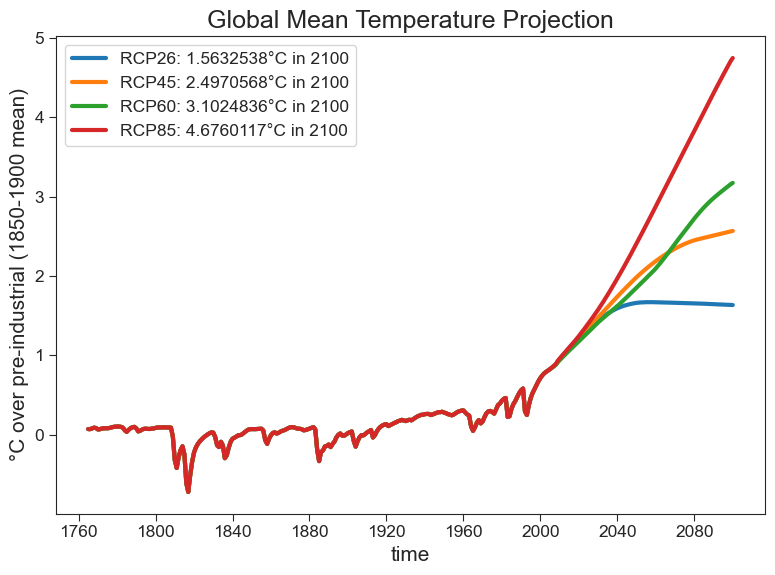

In [109]:
# Run model for each RCP
scen_list = []
for scen in rcps.groupby("scenario"):
    results_scen = pymagicc.run(scen)
    scen_list.append(results_scen)


results = scmdata.run_append(scen_list)

temperature_rel_to_1850_1900 = (
    results
    .filter(variable="Surface Temperature", region="World")
    .relative_to_ref_period_mean(year=range(1850, 1900 + 1))
)

# Loop for max temp
temp2100_list = []
for scen in ['RCP26', 'RCP45', 'RCP60', 'RCP85']:
    temp2100 = results.filter(variable = 'Surface Temperature', scenario = scen, year = 2100, region = 'World').values[0][0]
    temp2100_list.append(scen + ': ' + str(temp2100) + '°C in 2100')

# Plot results
ax = temperature_rel_to_1850_1900.lineplot()
plt.title("Global Mean Temperature Projection")
plt.ylabel("°C over pre-industrial (1850-1900 mean)")

# Get the handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, temp2100_list)

# Show the figure
plt.show()

## Question 3

The DICE version that we ran above is the 2016 version of Nordhaus' model. Recently, Nordhaus and team released a new version, documented in Barrage and Nordhaus (2023). Read the paper and compare it to what was in the 2016 version and summarize in 2-3 paragraphs what the main differences are with emphasis on explaining the technical differences (i.e., what coefficient changed and what were its new and old values). You may want to look through the code the Lint Barrange and William Nordhaus put online, which can be found here: https://yale.app.box.com/s/whlqcr7gtzdm4nxnrfhvap2hlzebuvvm

::: {.callout-tip}
## Answer 

The 2023 version of DICE made important updates, which, according to the working paper, resulted in "a significantly lower level of temperature of the cost-benefit optimal policy, a lower cost of reaching the 2° C target, an analysis of the impact of the Paris Accord, and a major increase in the estimated social cost of carbon" (Lint and Nordhaur 2023).

The first major change in parameters is that the pure rate of social time preference, $\rho$ decreased from 0.015 to 0.010, while the marginal utility of consumption, $\psi$, increased from 1.45 to 1.5. This means that the average discount rate for the time period (2020-2100) decreases from 4.2% to 3.9%.

Although the functional form remains the same, the 2023 model updates the damage function in several ways. The first component of damages is increased, where the "updated results imply a 1.62% GDP-equivalent loss at 3 °C warming over pre-industrial temperatures, up from 1.22% in the previous version." This update still omits damages due to biodiversity loss, ocean acidification, extreme events, or social unrest. Another update is the incorporation of tipping points, so that there is an additional 1% loss of global output due to 3°C warming. In addition, to account for uncertainty, the judgemental adjustment for other excluded impacts increased to 0.5% of output at 3°C warming. The combination of these changes mean that "the resulting damage coefficient is larger by a factor of almost two compared to the 2016 model and results in a major increase in the social cost of carbon." The model also includes an alternative damage function with a temperature-damage coefficient 3 times larger than the updated 2023 coefficient.  

The 2016 model only accounted for industrial CO_2 emissions, but the 2023 model now accounts for all "abatable" emissions. The model also makes revisions to the carbon cycle model by incorporating the DFAIR module to improve the previously linear carbon-cycle structure.  

---

Barrage, Lint, and William D. Nordhaus. *Policies, Projections, and the Social Cost of Carbon: Results from the DICE-2023 Model*. No. w31112. National Bureau of Economic Research, 2023.

:::